In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lal
import time
import emcee
import pycbc
import corner

import pycbc.waveform as wf
import lalsimulation as lalsim
from dynesty import NestedSampler
from collections import defaultdict
from pycbc.detector import Detector
from scipy.interpolate import interp1d

In [2]:
class PSD:
    def __init__(self, psd_filename, prepend_points = [], append_points = []):
        self.f_vals, self.psd_vals = np.loadtxt(psd_filename, unpack = True)
        self.prepend_points = prepend_points
        self.append_points = append_points

        for point in self.prepend_points:
            self.f_vals = np.concatenate([np.array([point[0]]), self.f_vals])
            self.psd_vals = np.concatenate([np.array([point[1]]), self.psd_vals])

        for point in self.append_points:
            self.f_vals = np.concatenate([self.f_vals, np.array([point[0]])])
            self.psd_vals = np.concatenate([self.psd_vals, np.array([point[1]])])

        self.psd = interp1d(self.f_vals, self.psd_vals)

In [3]:
ligo_H1_psd = '/home/mukesh/Academics/EW3/data/GW170814/H1_PSD_GW170814.txt'
ligo_L1_psd = '/home/mukesh/Academics/EW3/data/GW170814/L1_PSD_GW170814.txt'
V1_psd = '/home/mukesh/Academics/EW3/data/GW170814/V1_PSD_GW170814.txt'

H1_psd_int = PSD(ligo_H1_psd)
L1_psd_int = PSD(ligo_L1_psd)
V1_psd_int = PSD(V1_psd)

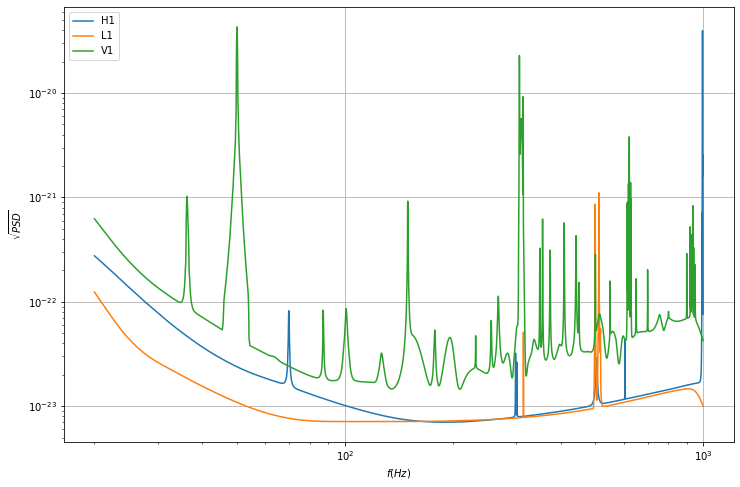

In [4]:
freq = np.linspace(20, 1000, 10000)
plt.figure(figsize=(12,8))
plt.loglog(freq, np.sqrt(H1_psd_int.psd(freq)), label='H1')
plt.loglog(freq, np.sqrt(L1_psd_int.psd(freq)), label='L1')
plt.loglog(freq, np.sqrt(V1_psd_int.psd(freq)), label='V1')
plt.xlabel('$f(Hz)$')
plt.ylabel('$\sqrt{PSD}$')
plt.legend(loc='best')
plt.grid()

In [5]:
def spher_harms_plus_cross_factors(inclination, l, m):
    
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, m)
    Y_lm_star = np.conj(lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, -m))
    
    if (l % 2):
        minus1l = -1
    else:
        minus1l = 1
        
    C_lm =  ( Y_lm + minus1l * Y_lm_star)
    D_lm = -1j * ( Y_lm - minus1l * Y_lm_star)
    
    return C_lm, D_lm

In [6]:
def waveform_lm_mode(fmin, fmax, df, mode, m1, m2, inclination, distance, approx):
    
    mode_array_dict = {
        "22": [[2, 2], [2, -2]],
        "32": [[3, 2], [3, -2]],
        "21": [[2, 1], [2, -1]],
        "44": [[4, 4], [4, -4]],
        "33": [[3, 3], [3, -3]],
        "43": [[4, 3], [4, -3]]
    }
    
    hp, hc = wf.get_fd_waveform(approximant= approx,
                                mass1 = m1, 
                                mass2 = m2, 
                                inclination=inclination,
                                distance=distance,
                                f_lower = fmin,
                                f_final = fmax,
                                delta_f = df,
                                mode_array = mode_array_dict[mode]
                                #coa_phase = coa_phase)
                               )
    # remove the angular dependence through dividing by spherical harmonics
    # so that we have to evaluate instrinsic part only once
    l = int(mode[0])
    m = int(mode[1])
    C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
    freq = hp.sample_frequencies.data
    hp = hp.data/C_lm
    hc = hc.data/(D_lm)
    h_intrinsic = hp
    return freq, h_intrinsic, hc

In [7]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
mle["psi"] = 0.0
mle["phi0"] = 0.0
mle["m1"] = 30.6
mle["m2"] = 25.2
mle["theta_jn"] = np.pi/4
mle["coa_phase"] = np.pi/4
mle["distance"] = 600.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0
modes = [ "22"]#, "33", "44"]

In [8]:
h_intrinsic = {}
signal = {}
f_min = 20.
f_max = 1000.
df = 0.1
detectors = ["H1", "L1", "V1"]
for det in detectors:
    signal[det] = 0.0
    Det = Detector(det)
    dt =  Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
    
    #taking time delays in account for each detector
    t_det =  mle["geocent_time"] + dt 
    fp, fc = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
    print("fplus = %f, fcross = %f for and time delay at the detector %s = %f "%(fp, fc, det, dt))
    
    for mode in modes:
        
        h_intrinsic[mode] = 0.0
        f, h_intrinsic[mode], _ = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
        l = int(mode[0])
        m = int(mode[1])
        
        lower_index = f >= f_min
        f = f[lower_index]
        h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
        upper_index = f <= f_max
        f = f[upper_index]
        h_intrinsic[mode] = h_intrinsic[mode][upper_index]
        
        C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
        # applying the phase factor depending on arrival time at the detector 
        phase_shift = (np.cos(2*np.pi*f*t_det + m*mle["phi0"]) + 1j*np.sin(2*np.pi*f*t_det + m*mle["phi0"]))
        #phase_shift = np.cos(2*np.pi*f*t_det) + 1j*np.sin(2*np.pi*f*t_det)
        #phase_shift = (np.cos(m*mle["phi0"]) + 1j*np.sin(m*mle["phi0"]))
        signal[det] += (fp*C_lm + fc*D_lm)*h_intrinsic[mode]*phase_shift

fplus = -0.272092, fcross = 0.431132 for and time delay at the detector H1 = 0.003695 
fplus = 0.421714, fcross = -0.300904 for and time delay at the detector L1 = -0.004739 
fplus = 0.441343, fcross = -0.153241 for and time delay at the detector V1 = 0.009089 


### Comparing the amplitudes at a detector

In [72]:
hp, hc = wf.get_fd_waveform(approximant= "IMRPhenomXPHM",
                                mass1 = mle["m1"], 
                                mass2 = mle["m2"], 
                                inclination=mle["theta_jn"],
                                distance=mle["distance"],
                                f_lower = f_min,
                                f_final = f_max,
                                delta_f = df,
                                mode_array = [[2,2],[2,-2]]
                                #coa_phase = coa_phase)
                               )
hplus = hp.data
hcross = hc.data
freq = hp.sample_frequencies.data
Det = Detector("V1")
fplus, fcross = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
hf = fplus*hplus + fcross*hcross
lower_index = freq >= f_min
freq = freq[lower_index]
hf = hf[lower_index]

upper_index = freq <= f_max
freq = freq[upper_index]
hf = hf[upper_index]

In [73]:
signal["V1"][5000], hf[5000]

((2.5321869180680886e-27+7.850878555663118e-28j),
 (2.5321847361600895e-27+7.850792464726277e-28j))

/home/mukesh/anaconda3/envs/pycbc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(20, 1215.91410658986)

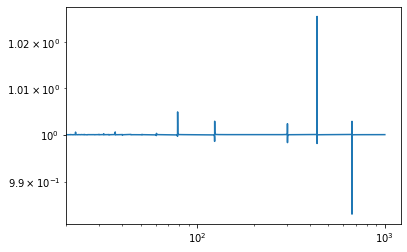

In [74]:
plt.loglog(f, np.real(signal["V1"]) / np.real(hf))
#plt.loglog(freq, abs(hf))
plt.xlim(20,)

### Conclusion:

Amplitudes match within $10^{-5}$ accuracy

In [9]:
H1_psd = H1_psd_int.psd(f)
L1_psd = L1_psd_int.psd(f)
V1_psd = V1_psd_int.psd(f)

In [12]:
def bayestarhm_source_model(frequency_array, intrinsic_signal, inclination, distance, ra, dec, psi, det, kwargs):
    # geocent_time, phi0,
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary    
    Det = Detector(det)
    geocent_time = mle["geocent_time"]
    #ra = mle["ra"]
    #dec = mle["dec"]
    #psi = mle["psi"]
    #distance = mle["distance"]
    #inclination = mle["theta_jn"]
    phi0 = mle["phi0"]
    dt = Det.time_delay_from_earth_center(ra, dec, geocent_time)
    t_det =  geocent_time + dt 
    fp, fc = Det.antenna_pattern(ra, dec, psi, geocent_time)
    
    signal_model = 0.0
    phase_shift_t_det = np.cos(2*np.pi*frequency_array*t_det) + 1j*np.sin(2*np.pi*frequency_array*t_det)
    #print(f)
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
        phase_shift = phase_shift_t_det*(np.cos(m*phi0) + 1j*np.sin(m*phi0))
        signal_model += (fp*C_lm + fc*D_lm)*intrinsic_signal[mode]*phase_shift
            
    return signal_model*(mle["distance"]/distance)

In [13]:
def log_bayestarhm_like(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22"]#, "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    #print(params_vec)
    for det in detectors:
        model = bayestarhm_source_model(frequency_array, h_intrinsic, params_vec[0], params_vec[1],  params_vec[2], \
                                         params_vec[3], params_vec[4],# params_vec[5], params_vec[6], 
                                        det, waveform_kwargs)
        likelihood_integrand = abs(signal[det] - model)**2
        psd = eval('%s_psd'%(det))
        log_likelihood += -2*np.trapz(likelihood_integrand/psd, frequency_array) 
    return log_likelihood

In [151]:
def prior_transform(u):
    
    x = np.array(u)
    
    x[0] = np.arccos(u[0] * 2. - 1.) # uniform in cos(inclination)
    
    x[1] = 1000*u[1] + 100 # 3000*np.sqrt(u[1]) + 100  # uniform in d_L
    
    x[2] = np.pi*u[2] # unifrom in ra
    
    x[3] = np.arcsin(u[3]*2 - 1) # uniform in sin(declination)
    
    x[4] = 2*np.pi*u[4] # unifrom in polarization
    
    #x[5] = mle["geocent_time"] + (u[5]*0.2 - 0.1) # unifrom in geocent_time
    
    #x[6] = 2*np.pi*u[6] # unifrom in source frame phase \phi_0
    
    return x

In [152]:
ndim=5
sampler = NestedSampler(log_bayestarhm_like, prior_transform, ndim, nact=10, nlive=1000, bound='none', sample='rwalk')
sampler.run_nested(dlogz=0.1)

17461it [1:17:55,  3.73it/s, +1000 | bound: 0 | nc: 1 | ncall: 382607 | eff(%):  4.825 | loglstar:   -inf < -0.031 <    inf | logz: -15.154 +/-  0.165 | dlogz:  0.000 >  0.100]


In [153]:
plt.hist(sampler.results["samples"][:,0], bins=50, density=True, histtype=u'step')
plt.axvline(x=mle["theta_jn"], c='r')
#plt.axvline(x=mle["theta_jn"]+np.pi/2, c='r')
#plt.axvline(x=mle["geocent_time"], c='r')
#plt.xlabel("$t_g$[secs]")
plt.show()

In [154]:
plt.hist(sampler.results["samples"][:,1], bins=50, density=True, histtype=u'step')
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L$(Mpc)")
plt.show()

Text(0, 0.5, '$\\iota$[rad]')

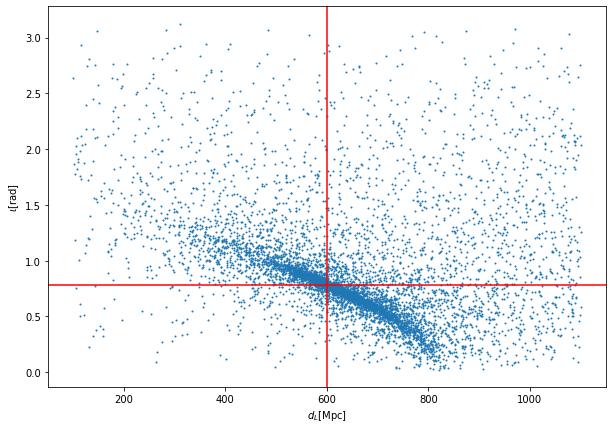

In [148]:
plt.figure(figsize=(10,7))
plt.scatter(sampler.results["samples"][:,1], sampler.results["samples"][:,0], s=1)
plt.axvline(x=600, c='r')
plt.axhline(y=np.pi/4, c='r')
plt.xlabel("$d_L$[Mpc]")
plt.ylabel("$\iota$[rad]")

In [128]:
plt.hist(sampler.results["samples"][:,0], bins=50, density=True, histtype=u'step')
plt.axvline(x=mle["theta_jn"], c='r')
#plt.axvline(x=mle["theta_jn"]+np.pi/2, c='r')
#plt.axvline(x=mle["geocent_time"], c='r')
#plt.xlabel("$t_g$[secs]")
plt.show()

In [129]:
plt.hist(sampler.results["samples"][:,1], bins=50, density=True, histtype=u'step')
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L$(Mpc)")
plt.show()

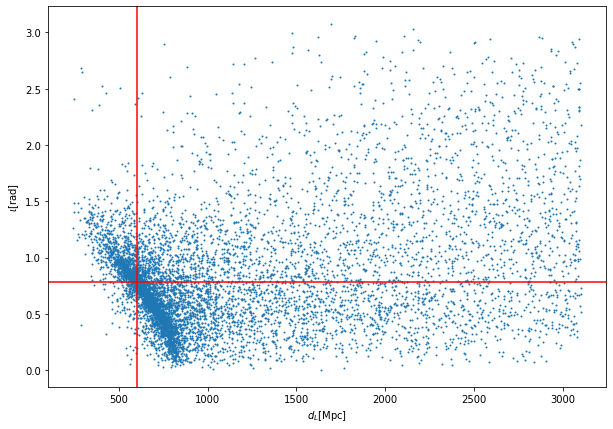

In [134]:
plt.figure(figsize=(10,7))
plt.scatter(sampler.results["samples"][:,1], sampler.results["samples"][:,0], s=1)
plt.axvline(x=600, c='r')
plt.axhline(y=np.pi/4, c='r')
plt.xlabel("$d_L$[Mpc]")
plt.ylabel("$\iota$[rad]")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/dL_iota_scatter_dynesty_sampling.png")

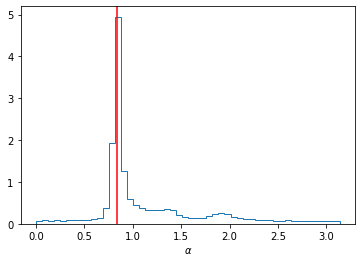

In [155]:
plt.hist(sampler.results["samples"][:,2], bins=50, density=True, histtype=u'step')
#plt.axvline(x=mle["ra"]+np.pi, c='g')
plt.axvline(x=mle["ra"], c='r')
plt.xlabel(r"$\alpha$")
plt.show()

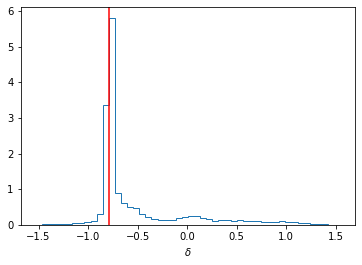

In [156]:
plt.hist(sampler.results["samples"][:,3], bins=50, density=True, histtype=u'step')
#plt.axvline(x=mle["dec"]+np.pi/2, c='g')
plt.axvline(x=mle["dec"], c='r')
plt.xlabel("$\delta$")
plt.show()

In [16]:
h_intrinsic = {}
signal = {}
f_min = 20.
f_max = 1000.
df = 0.1
detectors = ["H1", "L1", "V1"]
for det in detectors:
    signal[det] = 0.0
    Det = Detector(det)
    dt =  Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
    
    #taking time delays in account for each detector
    t_det =  mle["geocent_time"] + dt 
    fp, fc = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
    print("fplus = %f, fcross = %f for and time delay at the detector %s = %f "%(fp, fc, det, dt))
    
    for mode in modes:
        
        h_intrinsic[mode] = 0.0
        f, h_intrinsic[mode], _ = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
        l = int(mode[0])
        m = int(mode[1])
        
        lower_index = f >= f_min
        f = f[lower_index]
        h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
        upper_index = f <= f_max
        f = f[upper_index]
        h_intrinsic[mode] = h_intrinsic[mode][upper_index]
        
        C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
        # applying the phase factor depending on arrival time at the detector 
        phase_shift = (np.cos(2*np.pi*f*t_det + m*mle["phi0"]) + 1j*np.sin(2*np.pi*f*t_det + m*mle["phi0"]))
        #phase_shift = np.cos(2*np.pi*f*t_det) + 1j*np.sin(2*np.pi*f*t_det)
        #phase_shift = (np.cos(m*mle["phi0"]) + 1j*np.sin(m*mle["phi0"]))
        signal[det] += (fp*C_lm + fc*D_lm)*h_intrinsic[mode]*phase_shift

fplus = -0.272092, fcross = 0.431132 for and time delay at the detector H1 = 0.003695 
fplus = 0.421714, fcross = -0.300904 for and time delay at the detector L1 = -0.004739 
fplus = 0.441343, fcross = -0.153241 for and time delay at the detector V1 = 0.009089 


In [20]:
def bayestarhm_source_model(frequency_array, intrinsic_signal, inclination, distance, ra, dec, psi,geocent_time,phi0, det, kwargs):
     
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary    
    Det = Detector(det)
    #geocent_time = mle["geocent_time"]
    #ra = mle["ra"]
    #dec = mle["dec"]
    #psi = mle["psi"]
    #distance = mle["distance"]
    #inclination = mle["theta_jn"]
    #phi0 = mle["phi0"]
    
    dt = Det.time_delay_from_earth_center(ra, dec, geocent_time)
    t_det =  geocent_time + dt 
    fp, fc = Det.antenna_pattern(ra, dec, psi, geocent_time)
    
    signal_model = 0.0
    phase_shift_t_det = np.cos(2*np.pi*frequency_array*t_det) + 1j*np.sin(2*np.pi*frequency_array*t_det)
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
        phase_shift = phase_shift_t_det*(np.cos(m*phi0) + 1j*np.sin(m*phi0))
        signal_model += (fp*C_lm + fc*D_lm)*intrinsic_signal[mode]*phase_shift
            
    return signal_model*(mle["distance"]/distance)

In [21]:
def log_bayestarhm_like_debug(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22"]#, "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    #print(params_vec)
    for det in detectors:
        model = bayestarhm_source_model(frequency_array, h_intrinsic, params_vec[0], params_vec[1],  params_vec[2], 
                                         params_vec[3], params_vec[4], params_vec[5], params_vec[6],
                                        det, waveform_kwargs)
        d_inner_h_integrand = signal[det]*np.conj(model)
        h_innner_h_integrand = abs(model)**2
        likelihood_integrand = d_inner_h_integrand - h_innner_h_integrand / 2
        psd = eval('%s_psd'%(det))
        log_likelihood += 4*np.trapz(likelihood_integrand/psd, frequency_array) 
    return log_likelihood.real

In [23]:
iota = np.linspace(0, np.pi, 100)
dL = np.linspace(300, 800, 100)
ra_vec = np.linspace(0, 2*np.pi, 100)
dec_vec = np.linspace(-np.pi/2, np.pi/2, 100)
psi_vec = np.linspace(0, 2*np.pi, 100)
tg_vec = mle["geocent_time"] + np.linspace(-0.1, 0.1, 100)
phi0_vec = np.linspace(0, 2*np.pi, 100)

ras1, decs1 = np.meshgrid(ra_vec, dec_vec)
ras_grid = ras1.flatten()
decs_grid = decs1.flatten()
log_L = []
#for phi01 in phi0_vec:
for tg in tg_vec:
    params = np.array([mle["theta_jn"], mle["distance"], mle["ra"], mle["dec"], mle["psi"], tg, mle["phi0"]])
    log_L.append(log_bayestarhm_like_debug(params))

In [24]:
plt.plot(tg_vec, log_L)
plt.axvline(x=mle["geocent_time"], c='r')
plt.xlabel(r"$t_g$[sec]")
plt.ylabel(r"$\log\mathcal{L}$")

Text(0, 0.5, '$\\log\\mathcal{L}$')

In [27]:
tg1, phi01 = np.meshgrid(tg_vec, phi0_vec)
tg_grid = tg1.flatten()
phi0_grid = phi01.flatten()
log_L = []
for tg, phi0 in zip(tg_grid, phi0_grid):
    params = np.array([mle["theta_jn"], mle["distance"], mle["ra"], mle["dec"], mle["psi"], tg, phi0])
    log_L.append(log_bayestarhm_like_debug(params))

In [28]:
logL_tg_phi0 = np.reshape(log_L, tg1.shape)

Text(0, 0.5, '$\\varphi_0$[rad]')

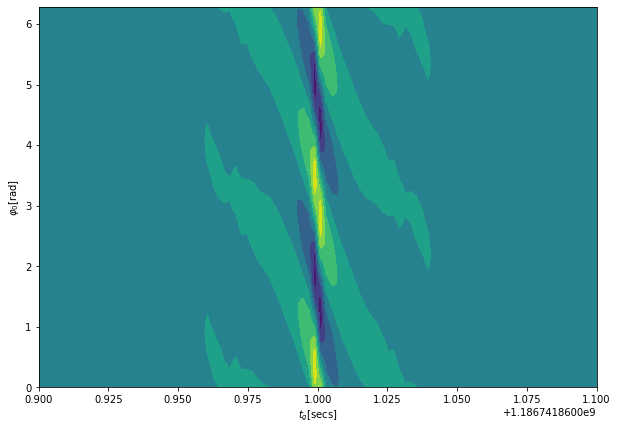

In [32]:
plt.figure(figsize=(10,7))
plt.contourf(tg1, phi01, logL_tg_phi0)
plt.xlabel(r"$t_g$[secs]")
plt.ylabel(r"$\varphi_0$[rad]")

### Emcee Sampling